In [1]:
######### Package Imports #########################################################################
import os, warnings, copy, torch, ax
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from ax.modelbridge.transforms.standardize_y import StandardizeY
from ax.modelbridge.transforms.unit_x import UnitX
from ax.modelbridge.transforms.remove_fixed import RemoveFixed
from ax.modelbridge.transforms.log import Log
from ax.core.base_trial import TrialStatus as T
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.slice import plot_slice

from optimpv import *
from optimpv.axBOtorch.axBOtorchOptimizer import axBOtorchOptimizer
from optimpv.DDfits.JVAgent import JVAgent
from optimpv.DDfits.ImpedanceAgent import ImpedanceAgent

import pySIMsalabim as sim
from pySIMsalabim.experiments.JV_steady_state import *
from pySIMsalabim.experiments.impedance import *

init_notebook_plotting()
warnings.filterwarnings('ignore') 
##############################################################################################
# Define the parameters to be fitted
params = []

mun = FitParam(name = 'l2.mu_n', value = 3e-4, bounds = [1e-5,1e-2], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_n$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mun)

mup = FitParam(name = 'l2.mu_p', value = 5e-4, bounds = [1e-5,1e-2], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_p$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mup)

bulk_tr = FitParam(name = 'l2.N_t_bulk', value = 4e20, bounds = [1e19,1e21], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T}$', unit='s', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(bulk_tr)

offset_l2_l1 = FitParam(name = 'offset_l2_l1.E_c', value = -0.1, bounds = [-0.2,0.0], values = None, start_value = None, log_scale = False, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\Delta E_{L2-L1}$', unit='eV', axis_type = 'linear', std = 0,encoding = None,force_log = False)
params.append(offset_l2_l1)

offset_l2_l3 = FitParam(name = 'offset_l2_l3.E_v', value = 0.1, bounds = [0,0.3], values = None, start_value = None, log_scale = False, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\Delta E_{L2-L3}$', unit='eV', axis_type = 'linear', std = 0,encoding = None,force_log = False)
params.append(offset_l2_l3)

Egap_l1 = FitParam(name = 'Egap_l1.E_v', value = 1.6, bounds = [1.55,1.65], type='fixed', values = None, start_value = None, log_scale = False, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$E_{gap,L1}$', unit='eV', axis_type = 'linear', std = 0,encoding = None,force_log = False)
params.append(Egap_l1)

offset_W_L = FitParam(name = 'offset_W_L.E_c', value = -0.1, bounds = [-0.2,0], type='fixed', values = None, start_value = None, log_scale = False, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\Delta W_L$', unit='eV', axis_type = 'linear', std = 0,encoding = None,force_log = False)
params.append(offset_W_L)

eps_r = FitParam(name = 'l2.eps_r', value = 24, bounds = [15,60], type='range', values = None, start_value = None, log_scale = False, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\epsilon_r$', unit='', axis_type = 'linear', std = 0,encoding = None,force_log = False)
params.append(eps_r)

Nions = FitParam(name = 'l2.N_ions', value = 1e22, bounds = [1e20,5e22], type='range', values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$C_{ions}$', unit='m$^{-3}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(Nions)

#original values
params_orig = copy.deepcopy(params)


[INFO 12-02 14:12:29] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 12-02 14:12:29] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


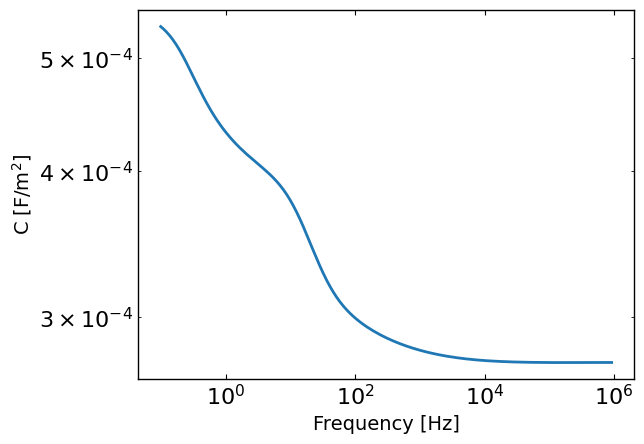

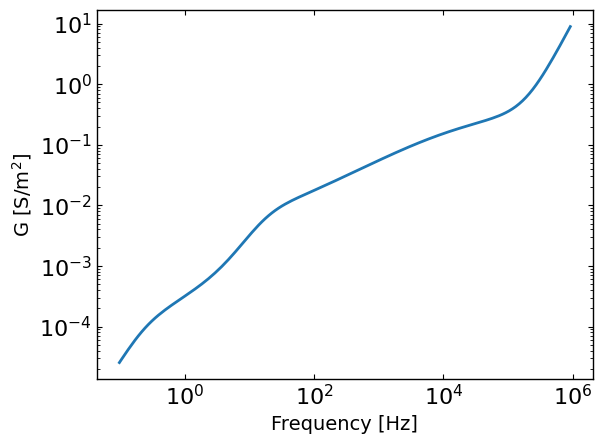

In [2]:
# Set the paths
session_path_simss = os.path.join('/home/lecorre/Desktop/pySIMsalabim/', 'SIMsalabim','SimSS')
simss_device_parameters = os.path.join(session_path_simss, 'simulation_setup.txt')
session_path_zimt = os.path.join('/home/lecorre/Desktop/pySIMsalabim/', 'SIMsalabim','ZimT')
zimt_device_parameters = os.path.join(session_path_zimt, 'simulation_setup.txt')

# Set the JV parameters
f_min = 1e-1
f_max = 1e6
f_steps = 20
V_0 = 0
del_V = 0.01
G_frac = 0
# Gfracs = None
UUID = str(uuid.uuid4())

cmd_pars = []
for param in params:
    if param.name != 'l2.C_np_bulk' and param.name != 'offset_l2_l1.E_c' and param.name != 'offset_l2_l3.E_v' and param.name != 'Egap_l1.E_v' and param.name != 'offset_W_L.E_c' and param.name != 'l2.N_ions':
        cmd_pars.append({'par':param.name, 'val':str(param.value)})
    elif param.name == 'offset_l2_l1.E_c':
        cmd_pars.append({'par':'l1.E_c', 'val':str(3.9-param.value)})
        vv = 3.9-param.value
    elif param.name == 'l2.N_ions':
        cmd_pars.append({'par':'l2.N_cation', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.N_anion', 'val':str(param.value)})
    elif param.name == 'l2.C_np_bulk':
        cmd_pars.append({'par':'l2.C_n_bulk', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.C_p_bulk', 'val':str(param.value)})

    elif param.name == 'offset_l2_l3.E_v':
        cmd_pars.append({'par':'l3.E_v', 'val':str(5.53-param.value)})
    
    elif param.name == 'Egap_l1.E_v':
        cmd_pars.append({'par':'l1.E_v', 'val': str(vv+param.value)})
    
    elif param.name == 'offset_W_L.E_c':
        cmd_pars.append({'par':'W_L', 'val':str(vv-param.value)})
# print(cmd_pars)

# Run the JV simulation
ret,mess = run_impedance_simu(zimt_device_parameters, session_path_zimt, f_min = f_min, f_max = f_max, f_steps = f_steps, V_0 = V_0, G_frac = G_frac, del_V = del_V, UUID=UUID, cmd_pars=cmd_pars, output_file = 'freqZ.dat')

# save data for fitting
X,y = [],[]

# Load the data
data = pd.read_csv(os.path.join(session_path_zimt, 'freqZ_'+UUID+'.dat'), sep=r'\s+')

# Extract the data
freqs = np.asarray(data['freq'].values)
X_imp = np.asarray(data['freq'].values)
yimp = np.asarray(data['C'].values)
yimp2 = np.asarray(data['G'].values)

plt.figure()

plt.plot(X_imp, yimp, '-', label='data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('C [F/m$^2$]')

plt.figure()

plt.plot(X_imp, yimp2, '-', label='data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('G [S/m$^2$]')
plt.show()


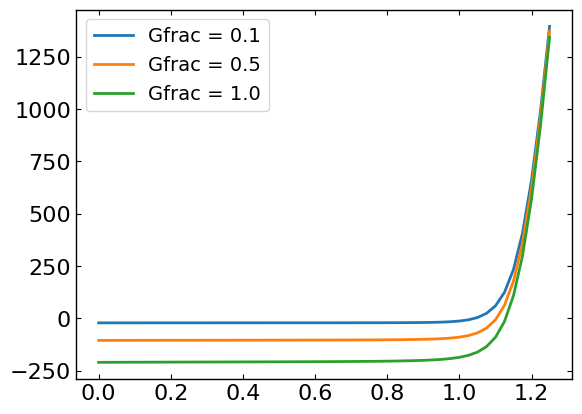

In [3]:
# Run the JV simulation
Gfracs = [0.1,0.5,1.0] # Fractions of the generation rate to simulate
# Gfracs = None
ret, mess = run_SS_JV(simss_device_parameters, session_path_simss, JV_file_name = 'JV.dat', varFile= 'Var.dat',G_fracs = Gfracs, parallel = True, max_jobs = 3, UUID=UUID, cmd_pars=cmd_pars)

# save data for fitting
X,y = [],[]
if Gfracs is None:
    data = pd.read_csv(os.path.join(session_path, 'JV_'+UUID+'.dat'), sep=r'\s+') # Load the data
    Vext = np.asarray(data['Vext'].values)
    Jext = np.asarray(data['Jext'].values)
    G = np.ones_like(Vext)

    X= Vext
    y = Jext

    plt.figure()
    plt.plot(X,y)
    plt.show()
else:
    for Gfrac in Gfracs:
        data = pd.read_csv(os.path.join(session_path_simss, 'JV_Gfrac_'+str(Gfrac)+'_'+UUID+'.dat'), sep=r'\s+') # Load the data
        Vext = np.asarray(data['Vext'].values)
        Jext = np.asarray(data['Jext'].values)
        G = np.ones_like(Vext)*Gfrac

        if len(X) == 0:
            X = np.vstack((Vext,G)).T
            y = Jext
        else:
            X = np.vstack((X,np.vstack((Vext,G)).T))
            y = np.hstack((y,Jext))


    plt.figure()
    for Gfrac in Gfracs:
        plt.plot(X[X[:,1]==Gfrac,0],y[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac))
    plt.legend()
    plt.show()



In [4]:
# Define the agents
metric1 = 'rmsre'
loss1 = 'log10'

imp = ImpedanceAgent(params, [X_imp,X_imp], [yimp,yimp2], session_path_zimt, metric = [metric1,metric1], loss = [loss1,loss1], threshold=[-0.5,-0.5],minimize=[True,True],exp_format=['Cf','Gf'],f_min = f_min, f_max = f_max, f_steps = f_steps, V_0 = V_0, G_frac = G_frac, del_V = del_V, simulation_setup=zimt_device_parameters)

metric2 = 'rmsre'
loss2 = 'log10'

jv = JVAgent(params, [X], [y], session_path_simss, simulation_setup=simss_device_parameters, parallel = True, max_jobs = 3, metric = [metric2], loss = [loss2], threshold=[-0.5],minimize=[True],exp_format=['JV'])

In [5]:
# Define the model kwargs
model_kwargs_list = [{},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogExpectedHypervolumeImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}]#,'surrogate':Surrogate(MultiTaskGP)}]

# Define the optimizer
optimizer = axBOtorchOptimizer(params = params, agents =  [imp, jv], models = ['SOBOL','BOTORCH_MODULAR'],n_batches = [1,30], batch_size = [10,2], ax_client = None,  max_parallelism = 10, model_kwargs_list = None, model_gen_kwargs_list = None, name = 'ax_opti')

In [6]:
optimizer.optimize()

[INFO 12-02 14:12:39] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-02 14:12:39] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='l2.mu_n', parameter_type=FLOAT, range=[1e-05, 0.01], log_scale=True), RangeParameter(name='l2.mu_p', parameter_type=FLOAT, range=[1e-05, 0.01], log_scale=True), RangeParameter(name='l2.N_t_bulk', parameter_type=FLOAT, range=[1e+19, 1e+21], log_scale=True), RangeParameter(name='offset_l2_l1.E_c', parameter_type=FLOAT, range=[-0.2, 0.0]), RangeParameter(name='offset_l2_l3.E_v', parameter_type=FLOAT, range=[0.0, 0.3]), FixedParameter(name='Egap_l1.E_v', parameter_type=FLOAT, value=1.6), FixedParameter(name='offset_W_L.E_c', parameter_type=FLOAT, value=-0.1), RangeParameter(name='l2.eps_r', parameter_type=FLOAT, range=[15.0, 60.0]), RangeParameter(name

OrderedDict({59: ({'l2.mu_n': 5.719629785408305e-05, 'l2.mu_p': 0.0017014929697806028, 'l2.N_t_bulk': 1e+21, 'offset_l2_l1.E_c': -0.031174320836255848, 'offset_l2_l3.E_v': 0.21731337547197757, 'l2.eps_r': 24.121937302212274, 'l2.N_ions': 1.0602154057840609e+22, 'Egap_l1.E_v': 1.6, 'offset_W_L.E_c': -0.1}, ({'Imp_Cf_rmsre': np.float64(-2.123413081477253), 'Imp_Gf_rmsre': np.float64(-1.341397439351932), 'JV_JV_rmsre': np.float64(-0.9425466649479332)}, {'Imp_Cf_rmsre': {'Imp_Cf_rmsre': nan, 'Imp_Gf_rmsre': 0.0, 'JV_JV_rmsre': 0.0}, 'Imp_Gf_rmsre': {'Imp_Cf_rmsre': 0.0, 'Imp_Gf_rmsre': nan, 'JV_JV_rmsre': 0.0}, 'JV_JV_rmsre': {'Imp_Cf_rmsre': 0.0, 'Imp_Gf_rmsre': 0.0, 'JV_JV_rmsre': nan}})), 52: ({'l2.mu_n': 2.498788890602936e-05, 'l2.mu_p': 0.0026520691441815182, 'l2.N_t_bulk': 1e+21, 'offset_l2_l1.E_c': -0.03883517515864948, 'offset_l2_l3.E_v': 0.20544415561900373, 'l2.eps_r': 23.978135687017772, 'l2.N_ions': 1.067550714913793e+22, 'Egap_l1.E_v': 1.6, 'offset_W_L.E_c': -0.1}, ({'Imp_Cf_r

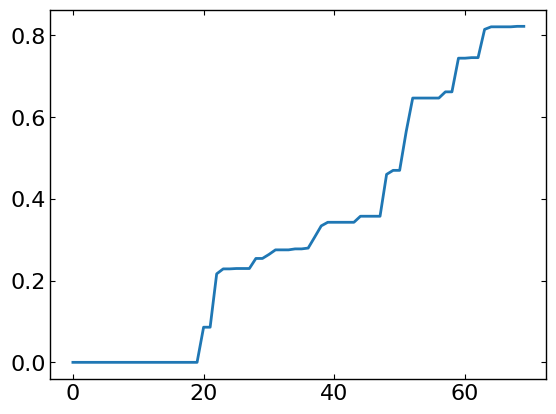

In [7]:
ax_client = optimizer.ax_client
pareto = ax_client.get_pareto_optimal_parameters(use_model_predictions=False)
best_keys = list(pareto.keys())
print(pareto)
plt.figure()
plt.plot(ax_client.get_trace())

#find max in get_trace
max_val = np.max(ax_client.get_trace())
index_max = np.argmax(ax_client.get_trace())
index_max = best_keys[0]
best_parameters = pareto[index_max][0]

imp.params_w(best_parameters,imp.params)
print(imp.get_SIMsalabim_clean_cmd(imp.params))
imp.package_SIMsalabim_files(imp.params,'zimt')

In [8]:
# plot the evolution of the optimization
name_metric = optimizer.all_metrics[0]
# name_metric = optimizer.all_metrics[1]

render(ax_client.get_contour_plot(param_x="l2.mu_n", param_y="l2.mu_p", metric_name=name_metric))

model = ax_client.generation_strategy.model

render(plot_slice(model=model, param_name="l2.N_t_bulk", metric_name=name_metric))


[INFO 12-02 14:47:07] ax.service.ax_client: Retrieving contour plot with parameter 'l2.mu_n' on X-axis and 'l2.mu_p' on Y-axis, for metric 'Imp_Cf_rmsre'. Remaining parameters are affixed to the middle of their range.


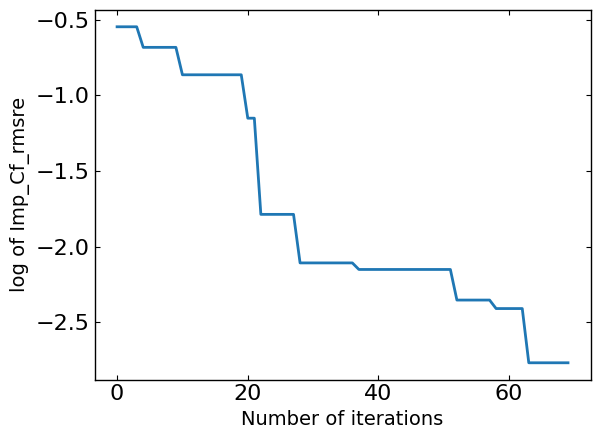

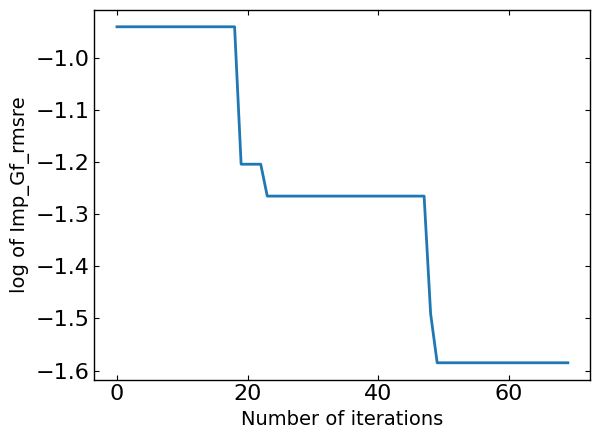

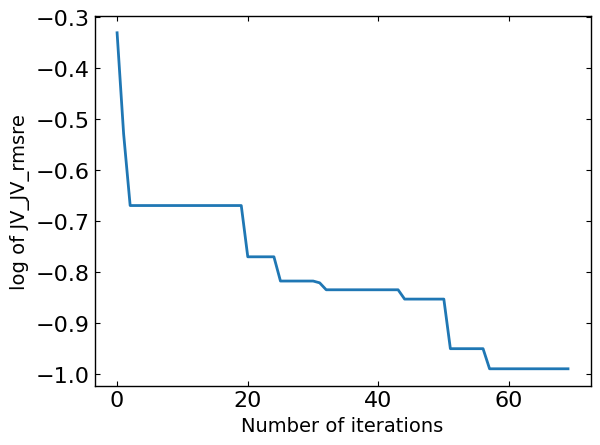

In [9]:
data = ax_client.experiment.fetch_data()
# split df by metric name 
data = data.df
metric1_df = data[data["metric_name"] == optimizer.all_metrics[0]]
metric2_df = data[data["metric_name"] == optimizer.all_metrics[1]]
metric3_df = data[data["metric_name"] == optimizer.all_metrics[2]]

# reset index
metric1_df = metric1_df.reset_index(drop=True)
metric2_df = metric2_df.reset_index(drop=True)
metric3_df = metric3_df.reset_index(drop=True)
# plt.figure()
# plt.plot(np.minimum.accumulate(data.df["mean"]), label="Best value seen so far")

plt.figure()
plt.plot(np.minimum.accumulate(metric1_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[0])

plt.figure()
plt.plot(np.minimum.accumulate(metric2_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[1])

plt.figure()
plt.plot(np.minimum.accumulate(metric3_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[2])

plt.show()

In [10]:
# create dic with keys same as ax_client.experiment.trials[0].arm.parameters
dumdic = {}
for key in ax_client.experiment.trials[0].arm.parameters.keys():
    dumdic[key] = []

# fill the dic with the values of the parameters
for i in range(len(ax_client.experiment.trials)):
    if ax_client.experiment.trials[i].status == T.COMPLETED:
        for key in ax_client.experiment.trials[i].arm.parameters.keys():
            dumdic[key].append(ax_client.experiment.trials[i].arm.parameters[key])


data = ax_client.experiment.fetch_data().df

target1 = data[data['metric_name'] == optimizer.all_metrics[0]]['mean']

dumdic[optimizer.all_metrics[0]] = list(target1)

target2 = data[data['metric_name'] ==  optimizer.all_metrics[1]]['mean']

dumdic[optimizer.all_metrics[1]] = list(target2)

target3 = data[data['metric_name'] ==  optimizer.all_metrics[2]]['mean']

dumdic[optimizer.all_metrics[2]] = list(target3)

dumdic['iteration'] = list(data[data['metric_name'] == optimizer.all_metrics[0]]['trial_index'])

df = pd.DataFrame(dumdic)



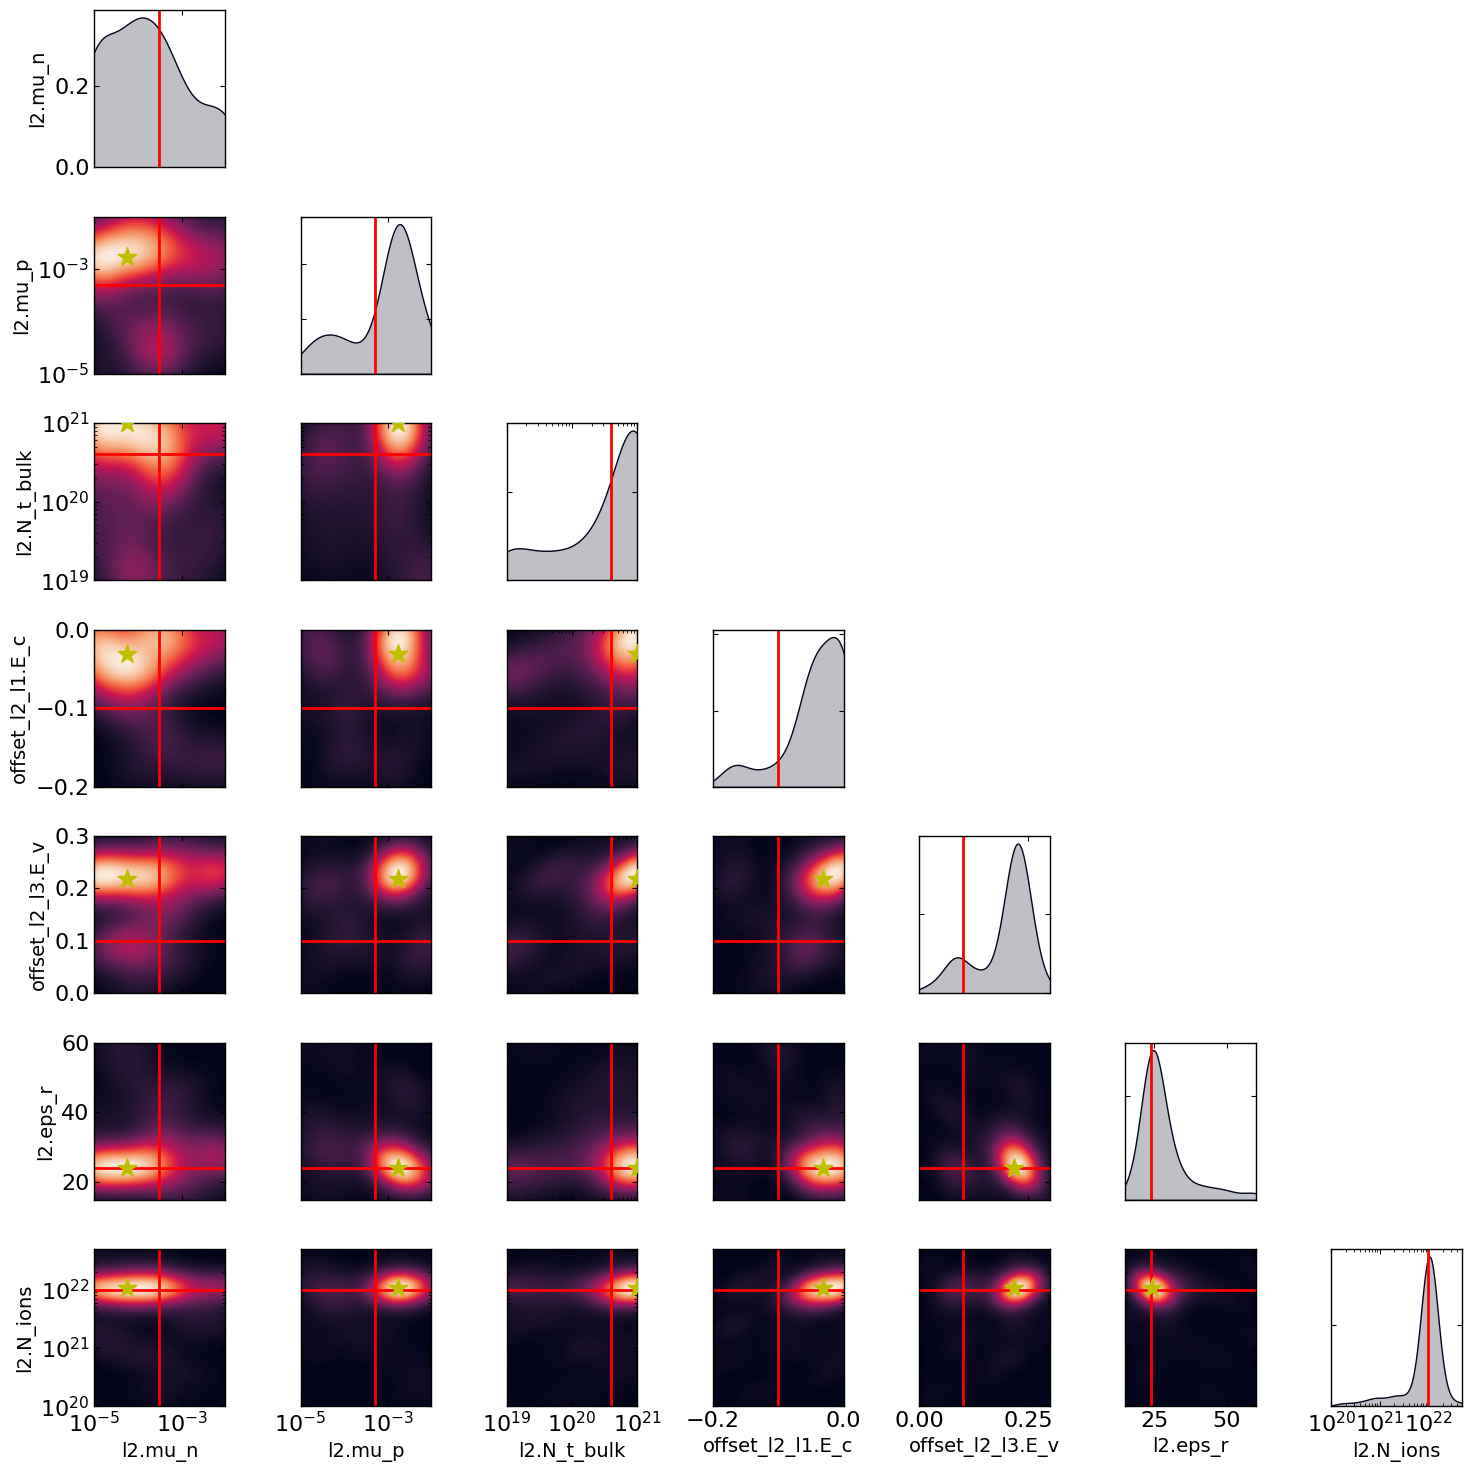

In [11]:
# get name of all parameters that are not 'fixed'
names = []
log_scale = []
axis_limits = []
for p in params:
    if p.type != 'fixed':
        names.append(p.name)
        log_scale.append(p.axis_type == 'log')
        axis_limits.append(p.bounds)


# Get all combinations of names
comb = list(combinations(names, 2))

# Determine the grid size
n = len(names)
fig, axes = plt.subplots(n, n, figsize=(15, 15))

# Plot each combination in the grid
for i, xx in enumerate(names):
    for j, yy in enumerate(names):
        xval = np.nan
        yval = np.nan

        for p in params_orig:
            if p.name == xx:
                xval = p.value
            if p.name == yy:
                yval = p.value

        ax = axes[i, j]
        if i == j:
            # kde plot on the diagonal
            sns.kdeplot(x=yy, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=log_scale[names.index(xx)])

            ax.axvline(x=yval, color='r', linestyle='-')
            # put point at the best value top of the axis
           

            if log_scale[names.index(yy)]:
                ax.set_xscale('log')
                ax.set_xlim(axis_limits[names.index(yy)])
            else:
                ax.set_xlim(axis_limits[names.index(yy)])
            
            # put x label on the top
            # except for the last one
            if i < n - 1:
                ax.xaxis.set_label_position('top')
                ax.xaxis.tick_top()

        elif i > j:
            kind = 'kde'
            if kind == 'scatter':
                sns.scatterplot(x=yy, y=xx, data=df, ax=ax, color="#03051A")
                ax.set_xscale('log')
                ax.set_yscale('log')
            else:
                sns.kdeplot(x=yy, y=xx, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=(log_scale[names.index(yy)], log_scale[names.index(xx)]))

            xval = np.nan
            yval = np.nan
            for p in params_orig:
                if p.name == xx:
                    xval = p.value
                elif p.name == yy:
                    yval = p.value

            # Plot as line over the full axis
            ax.axhline(y=xval, color='r', linestyle='-')
            ax.axvline(x=yval, color='r', linestyle='-')
            ax.scatter(best_parameters[yy], best_parameters[xx], c='y', marker='*', s=200, zorder=10)
            
            ax.set_xlim(axis_limits[names.index(yy)])
            ax.set_ylim(axis_limits[names.index(xx)])
        else:
            ax.set_visible(False)

        if j > 0:
            ax.set_yticklabels([])
            # remove the y axis label
            ax.set_ylabel('')
        if i < n - 1:
            ax.set_xticklabels([])
            # remove the x axis label
            ax.set_xlabel('')

        if i == n - 1:
            ax.set_xlabel(yy)
        if j == 0:
            ax.set_ylabel(xx)

plt.tight_layout()
plt.show()


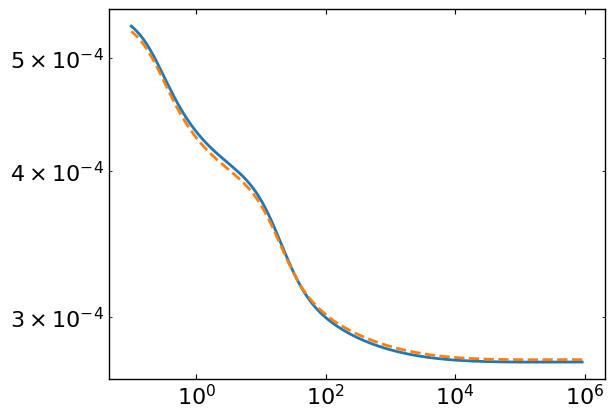

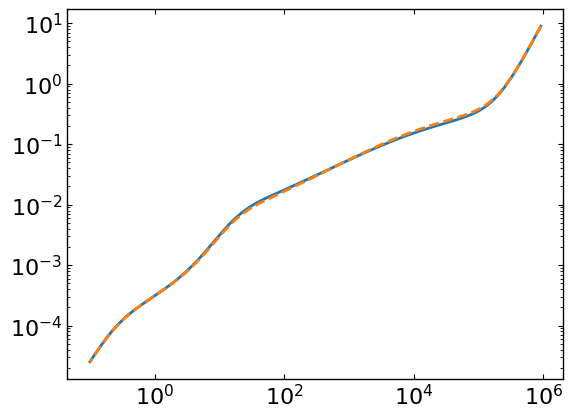

In [12]:
# rerun the simulation with the best parameters
# Cf
yfit = imp.run(best_parameters,X_imp,exp_format='Cf')
# Gf
yfit2 = imp.run(best_parameters,X_imp,exp_format='Gf')

plt.figure()
plt.plot(X_imp, yimp, '-', label='data')
plt.plot(X_imp, yfit, '--', label='fit')
plt.xscale('log')
plt.yscale('log')

plt.figure()
plt.plot(X_imp, yimp2, '-', label='data')
plt.plot(X_imp, yfit2, '--', label='fit')
plt.xscale('log')
plt.yscale('log')



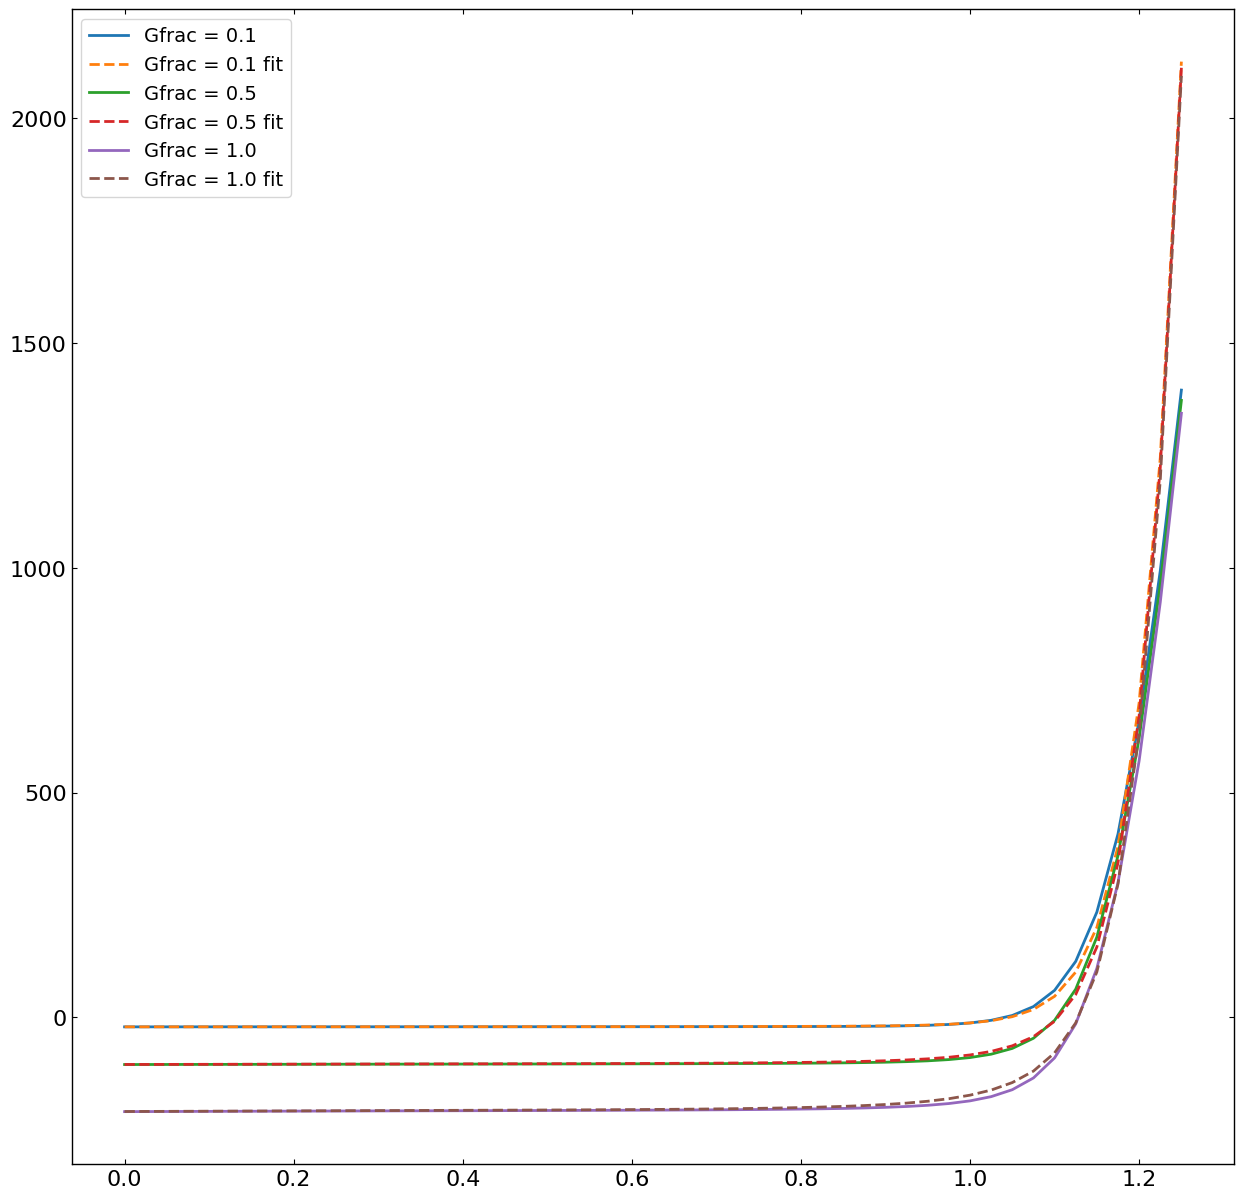

In [13]:
# rerun the simulation with the best parameters
yfit = jv.run(parameters=best_parameters)

plt.figure(figsize=(15,15))
for Gfrac in Gfracs:
    plt.plot(X[X[:,1]==Gfrac,0],y[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac))
    plt.plot(X[X[:,1]==Gfrac,0],yfit[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac)+' fit',linestyle='--')
plt.legend()
plt.show()

In [14]:
# Clean up the output files (comment out if you want to keep the output files)
sim.clean_all_output(session_path_zimt)
sim.clean_up_output('freqZ',session_path_zimt)
sim.delete_folders('tmp',session_path_zimt)
sim.clean_all_output(session_path_simss)
sim.delete_folders('tmp',session_path_simss)